### MR0 PulSeq Simulation

Timing check passed successfully


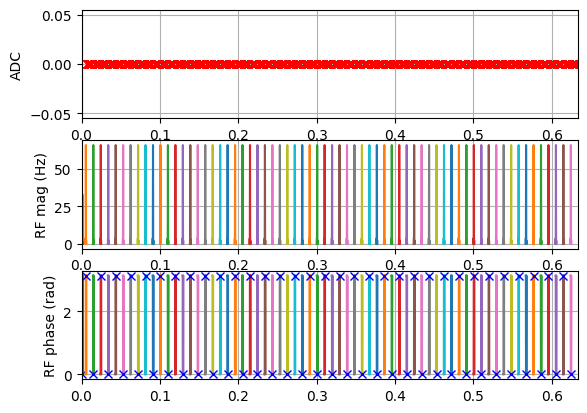

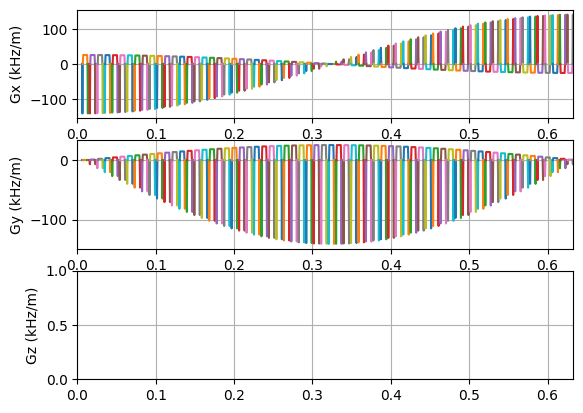

VoxelGridPhantom
FOV: base * rel = tensor([0.2000, 0.2000, 0.0080]) * tensor([1., 1., 1.]) = tensor([0.2000, 0.2000, 0.0080])


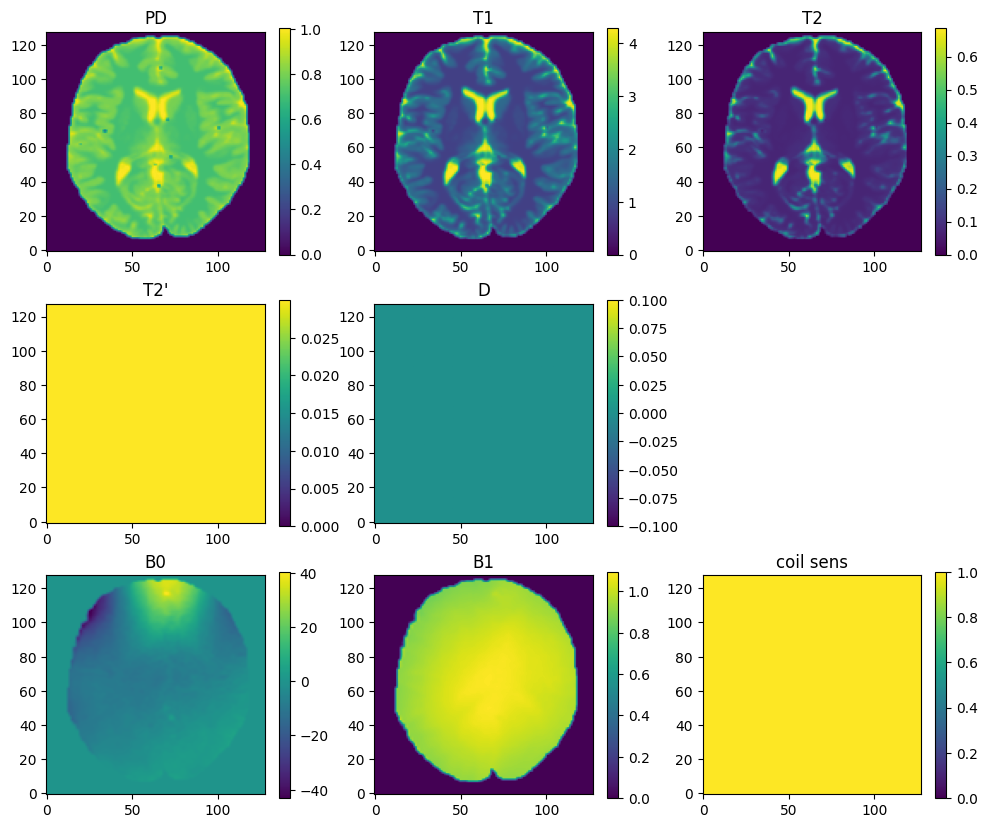

/home/atuin/b143dc/b143dc15/.conda/envs/mrtwin/lib/python3.9/site-packages/MRzeroCore/phantom/voxel_grid_phantom.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2,


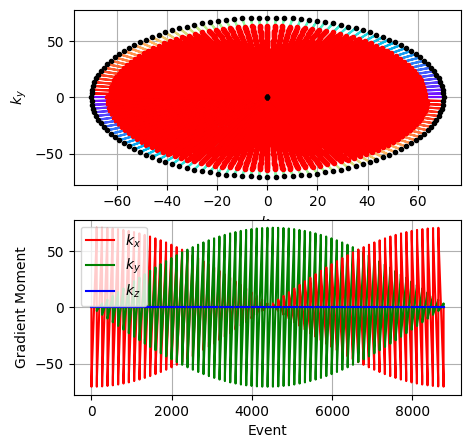

>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.000594053 s
Compute Graph
Computing Graph: 0.052392498 s
Analyze Graph
Analyzing Graph: 0.000717405 s
Converting Rust -> Python: 0.015431083 s
<<<< Rust <<<<
Calculating repetition 67 / 67 - done


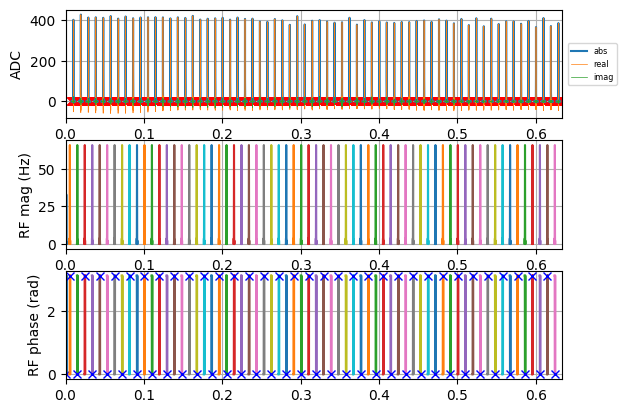

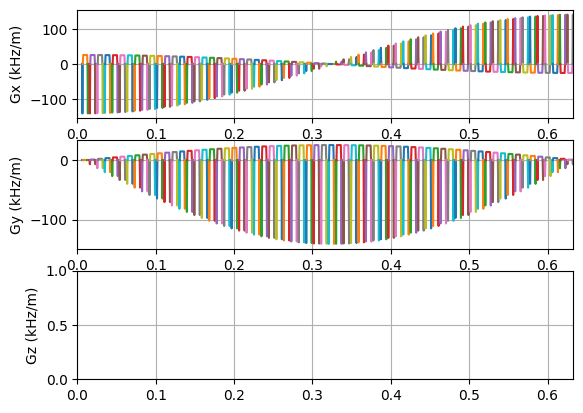

In [10]:
# %% S0. SETUP env
from matplotlib import pyplot as plt

import MRzeroCore as mr0
import numpy as np
import pypulseq as pp

import h5py
import pywt
import torch
import util

# makes the ex folder your working directory
import os
# get the current dir of this file
DIR = os.path.dirname(os.getcwd())

os.chdir(os.path.abspath(os.getcwd()))
experiment_id = 'exF02_undersampled_radial'

# %% S1. SETUP sys

# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=50 * 10e-6
)

# %% S2. DEFINE the sequence
seq = pp.Sequence()

# Define FOV and resolution
fov = 1000e-3
slice_thickness = 8e-3
sz = (128, 128) # spin system size / resolution
Nread = sz[0]   # frequency encoding steps/samples
Nphase = 66     # phase encoding steps/samples - number of radial spokes

# Nphase * pi / 2

# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=6 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
# rf1 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)

# Define other gradients and ADC events
gx = pp.make_trapezoid(channel='x', flat_area=Nread, flat_time=5e-3, system=system)
gy = pp.make_trapezoid(channel='y', flat_area=Nread, flat_time=5e-3, system=system)

gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)
gy_pre = pp.make_trapezoid(channel='y', area=-gx.area / 2, duration=1e-3, system=system)

adc = pp.make_adc(num_samples=Nread, duration=5e-3, phase_offset=0 * np.pi / 180, delay=gx.rise_time, system=system)

rf_phase = 180
rf_inc = 180

# ======
# CONSTRUCT SEQUENCE
# ======
sdel = 1e-0

rf0, _, _ = pp.make_sinc_pulse(
    flip_angle=6 / 2 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
seq.add_block(rf0)
seq.add_block(pp.make_delay(3e-3))

for ii in range(-Nphase // 2, Nphase // 2):  # e.g. -64:63
    rf1.phase_offset = rf_phase / 180 * np.pi   # set current rf phase

    adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC
    # increment additional pahse
    rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]

    seq.add_block(rf1)

    gx = pp.make_trapezoid(channel='x', flat_area=-Nread * np.sin(ii / Nphase * np.pi) + 1e-7, flat_time=5e-3, system=system)
    gy = pp.make_trapezoid(channel='y', flat_area=Nread * np.cos(ii / Nphase * np.pi) + 1e-7, flat_time=5e-3, system=system)

    gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)
    gy_pre = pp.make_trapezoid(channel='y', area=-gy.area / 2, duration=1e-3, system=system)

    seq.add_block(gx_pre, gy_pre)
    seq.add_block(adc, gx, gy)
    # seq.add_block(adc,gx,gy)
    seq.add_block(gx_pre, gy_pre)
    # seq.add_block(make_delay(10))


# %% S3. CHECK, PLOT and WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# PLOT sequence
sp_adc, t_adc = util.pulseq_plot(seq, clear=False, figid=(11,12))

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'gre')
seq.write('out/external.seq')
seq.write('out/' + experiment_id + '.seq')


# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
if 1:
    # (i) load a phantom object from file
    # obj_p = mr0.VoxelGridPhantom.load_mat('../data/phantom2D.mat')
    obj_p = mr0.VoxelGridPhantom.load_mat('../data/numerical_brain_cropped.mat')
    obj_p = obj_p.interpolate(sz[0], sz[1], 1)
    # Manipulate loaded data
    obj_p.T2dash[:] = 30e-3
    obj_p.D *= 0 
    obj_p.B0 *= 1    # alter the B0 inhomogeneity
else:
    # or (ii) set phantom  manually to a pixel phantom. Coordinate system is [-0.5, 0.5]^3
    obj_p = mr0.CustomVoxelPhantom(
        pos=[[-0.4, -0.4, 0], [-0.4, -0.2, 0], [-0.3, -0.2, 0], [-0.2, -0.2, 0], [-0.1, -0.2, 0]],
        PD=[1.0, 1.0, 0.5, 0.5, 0.5],
        T1=1.0,
        T2=0.1,
        T2dash=0.1,
        D=0.0,
        B0=0,
        voxel_size=0.1,
        voxel_shape="box"
    )

obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()


# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot

# Read in the sequence
seq_file = mr0.PulseqFile("out/external.seq")
# seq_file.plot()
seq0 = mr0.Sequence.from_seq_file(seq_file)
seq0.plot_kspace_trajectory()
kspace_loc = seq0.get_kspace()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p)

# PLOT sequence with signal in the ADC subplot
plt.close(11);plt.close(12)
sp_adc, t_adc = util.pulseq_plot(seq, clear=False, signal=signal.numpy())

kspace_adc = torch.reshape((signal), (Nphase, Nread)).clone().t()

### NUFFT Reconstruction

> NUFFT recon with density compensation function
tensor(64.)
nufft_adj -> image shape:  torch.Size([1, 1, 128, 128, 2])


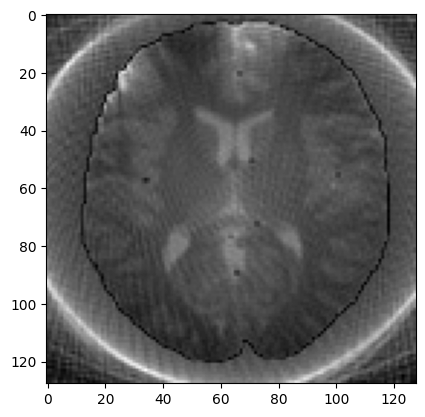

In [11]:
# %% S6:. NUFFT reconstruction with density compensation
# Zhengguo Tan <zhengguo.tan@gmail.com>

print('> NUFFT recon with density compensation function')

import torchkbnufft as tkbn

# traj
traj = torch.reshape(kspace_loc, (Nphase, Nread, kspace_loc.shape[-1]))
traj = traj[..., :2]

print(torch.max(abs(traj)))

traj = traj/Nread * np.pi * 2  # [-pi, pi]
traj = torch.reshape(traj, (-1, 2)).transpose(1, 0)

# compute density compensation function
dcf = (traj[0, ...]**2 + traj[1, ...]**2)**0.5
dcf = dcf.reshape(1, -1).repeat(2, 1).transpose(1, 0)

# kdat
kdat = torch.view_as_real(kspace_adc.transpose(1, 0))
kdat = torch.reshape(kdat, (1, 1, -1, 2))

img_shape = [Nread] * 2

# define nufft adjoint operator
nufft_adj = tkbn.KbNufftAdjoint(im_size=img_shape)

recon_nufft = nufft_adj(kdat * dcf, traj)

print('nufft_adj -> image shape: ', recon_nufft.shape)


# define nufft forward operator
nufft_fwd = tkbn.KbNufft(im_size=img_shape)

R = recon_nufft.cpu().detach().numpy()

R1 = R[..., 0] + 1j * R[..., 1]
R1 = np.flip(np.swapaxes(R1, -1, -2), -2)

plt.imshow(abs(np.squeeze(R1)), cmap='gray')
plt.show()

In [12]:
print(traj.shape)
print(torch.max(abs(traj)))

torch.Size([2, 8448])
tensor(3.1416)


### Gradient Delay

In [26]:
# %% S7:. https://doi.org/10.1002/mrm.10501
# Zhengguo Tan <zhengguo.tan@gmail.com>

print('> NUFFT recon with density compensation function')

import torchkbnufft as tkbn

# traj
traj = torch.reshape(kspace_loc, (Nphase, Nread, kspace_loc.shape[-1]))
traj = traj[..., :2]

print(traj.shape)

traj = traj/Nread * np.pi * 2

# inserting gradient delays
gd_0 = 0.05
gd_1 = 0.08

for ii in range(-Nphase//2, Nphase//2):
    traj[ii, :, 0] += gd_0 * torch.as_tensor(np.sin(ii / Nphase * np.pi))
    traj[ii, :, 1] += gd_1 * torch.as_tensor(np.cos(ii / Nphase * np.pi))

traj = torch.reshape(traj, (-1, 2)).transpose(1, 0)

# compute density compensation function
dcf = (traj[0, ...]**2 + traj[1, ...]**2)**0.5
dcf = dcf.reshape(1, -1).repeat(2, 1).transpose(1, 0)

# kdat
kdat = torch.view_as_real(kspace_adc.transpose(1, 0))
kdat = torch.reshape(kdat, (1, 1, -1, 2))

img_shape = [Nread] * 2

# define nufft adjoint operator
nufft_adj = tkbn.KbNufftAdjoint(im_size=img_shape)

recon_nufft = nufft_adj(kdat * dcf, traj)

print('nufft_adj -> image shape: ', recon_nufft.shape)


# define nufft forward operator
nufft_fwd = tkbn.KbNufft(im_size=img_shape)

R = recon_nufft.cpu().detach().numpy()

R1_gd = R[..., 0] + 1j * R[..., 1]
R1_gd = np.flip(np.swapaxes(R1_gd, -1, -2), -2)

> NUFFT recon with density compensation function
torch.Size([66, 128, 2])
nufft_adj -> image shape:  torch.Size([1, 1, 128, 128, 2])


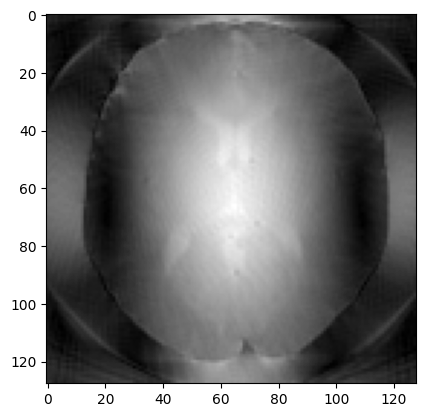

In [27]:
plt.imshow(abs(np.squeeze(R1_gd)), cmap='gray')
plt.show()

### Compressed Sensing Reconstruction

> Compressed sensing recon for radial sampled data
tensor([3003527.5000])
tensor([407139.0938])
tensor([959964.9375])
tensor([1010150.1875])
tensor([1015788.6875])
tensor([1016494.6250])
tensor([1016586.1250])
tensor([1016598.3125])
tensor([1016599.6875])
tensor([1016600.2500])
tensor([1016600.1250])
tensor([1016600.1875])
tensor([1016600.5000])
tensor([1016600.3750])
tensor([1016600.4375])
tensor([1016600.4375])
tensor([1016600.3125])
tensor([1016600.3750])
tensor([1016600.3750])
tensor([1016600.3750])
tensor([1016600.3750])
tensor([1016600.3750])
tensor([1016600.3750])
tensor([1016600.3750])
tensor([1016600.3750])
tensor([1016600.3125])
tensor([1016600.4375])
tensor([1016600.3125])
tensor([1016600.4375])
tensor([1016600.3125])
> iter 0000 residuum tensor(3.3021)
> iter 0001 residuum tensor(0.4393)
> iter 0002 residuum tensor(0.3048)
> iter 0003 residuum tensor(0.2151)
> iter 0004 residuum tensor(0.1554)
> iter 0005 residuum tensor(0.1155)
> iter 0006 residuum tensor(0.0887)
> iter 00

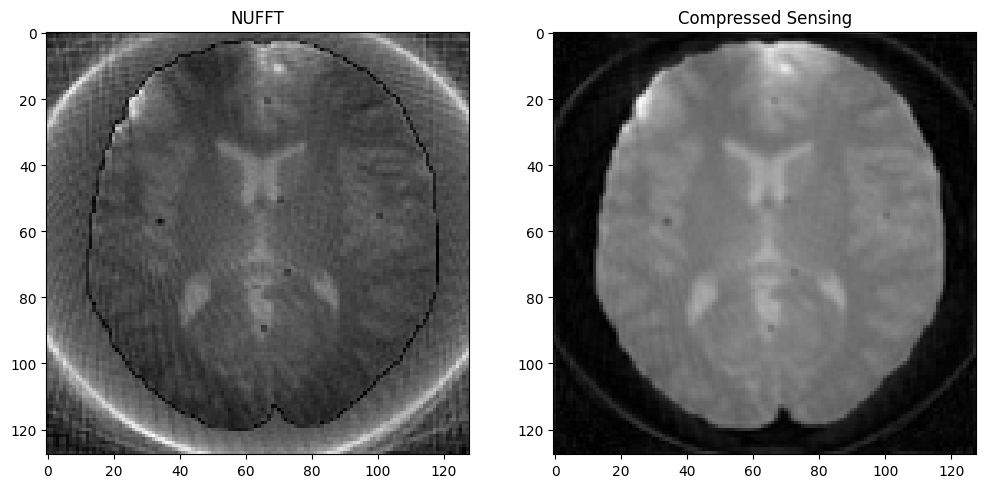

In [3]:
# %% S7:. Compressed Sensing reconstruction for radial sampling
# Zhengguo Tan <zhengguo.tan@gmail.com>

print('> Compressed sensing recon for radial sampled data')

def soft_thresh(input, lamda):

    abs_input = abs(input)

    sign = np.true_divide(input, abs_input,
                          out=np.zeros_like(input), where=abs_input!=0)

    magn = abs_input - lamda
    magn = (abs(magn) + magn) / 2

    return magn * sign


def prox_wav(input, lamda):

    if torch.is_tensor(input):
        input = input.cpu().detach().numpy()

    # pywt outputs numpy arrays
    cA, (cH, cV, cD) = pywt.dwt2(input, 'db4')

    cA_t = soft_thresh(cA, lamda)
    cH_t = soft_thresh(cH, lamda)
    cV_t = soft_thresh(cV, lamda)
    cD_t = soft_thresh(cD, lamda)

    wav_coef = cA_t, (cH_t, cV_t, cD_t)

    output = pywt.idwt2(wav_coef, 'db4')

    return torch.tensor(output)


# compute maximal eigenvalue:
x = torch.randn(size=recon_nufft.shape, dtype=recon_nufft.dtype)
for n in range(30):
    y = nufft_adj(nufft_fwd(x, traj), traj)
    max_eig = torch.linalg.norm(y).ravel()
    x = y / max_eig

    print(max_eig)


# Gradient method
Niter = 200

alpha = (1 / max_eig).cpu().detach().numpy().item()  # 0.001
lamda = 0.001

x = torch.zeros_like(recon_nufft)

for n in range(Niter):

    x_old = x.clone()

    r = nufft_fwd(x, traj) - kdat
    g = nufft_adj(r, traj)

    x = prox_wav(x - alpha * g, alpha * lamda)

    resid = (torch.linalg.norm(x - x_old).ravel()).ravel()

    print('> iter ' + str(n).zfill(4) + ' residuum ' + str(resid[0]))


R2 = torch.view_as_complex(x).cpu().detach().numpy()
R2 = np.flip(np.swapaxes(R2, -1, -2), -2)

f, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(abs(np.squeeze(R1)), cmap='gray')
ax[0].set_title('NUFFT')

ax[1].imshow(abs(np.squeeze(R2)), cmap='gray')
ax[1].set_title('Compressed Sensing')

plt.savefig(DIR + '/' + experiment_id + '.png',
            bbox_inches='tight', pad_inches=0, dpi=300)

tensor([2767141.2500])
tensor([244680.3750])
tensor([867326.1250])
tensor([996235.2500])
tensor([1013822.7500])
tensor([1016214.4375])
tensor([1016546.2500])
tensor([1016592.5000])
tensor([1016599.3125])
tensor([1016599.9375])
tensor([1016600.2500])
tensor([1016600.3125])
tensor([1016600.])
tensor([1016600.3750])
tensor([1016600.3125])
tensor([1016600.0625])
tensor([1016600.1875])
tensor([1016600.1250])
tensor([1016600.1250])
tensor([1016600.1875])
tensor([1016600.2500])
tensor([1016600.1875])
tensor([1016600.1875])
tensor([1016600.1875])
tensor([1016600.1875])
tensor([1016600.1875])
tensor([1016600.1875])
tensor([1016600.1875])
tensor([1016600.2500])
tensor([1016600.1250])
> iter 0000 residuum tensor(3.3021)
> iter 0001 residuum tensor(0.4393)
> iter 0002 residuum tensor(0.3048)
> iter 0003 residuum tensor(0.2151)
> iter 0004 residuum tensor(0.1554)
> iter 0005 residuum tensor(0.1155)
> iter 0006 residuum tensor(0.0887)
> iter 0007 residuum tensor(0.0706)
> iter 0008 residuum tensor(0

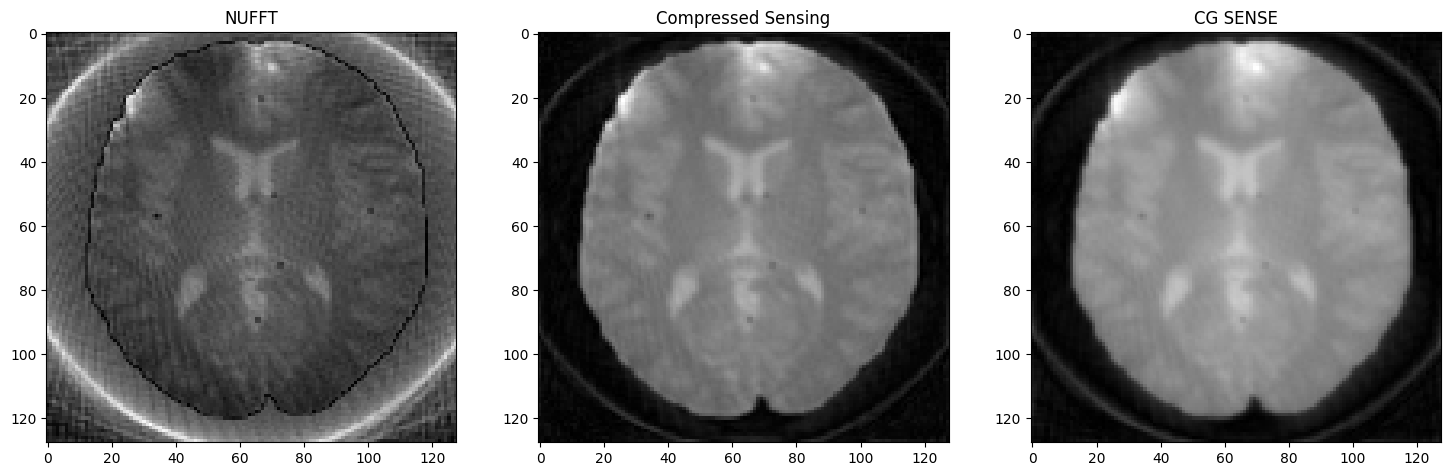

In [4]:
# %% S8:. CG SENSE without density compensation
# Zhengguo Tan <zhengguo.tan@gmail.com>

# compute maximal eigenvalue:
x = torch.randn(size=recon_nufft.shape, dtype=recon_nufft.dtype)
for n in range(30):
    y = nufft_adj(nufft_fwd(x, traj), traj)
    max_eig = torch.linalg.norm(y).ravel()
    x = y / max_eig

    print(max_eig)


# Gradient method
Niter = 50

alpha = (1 / max_eig).cpu().detach().numpy().item()
lamda = 0.001

x = torch.zeros_like(recon_nufft)

for n in range(Niter):

    x_old = x.clone()

    r = nufft_fwd(x, traj) - kdat
    g = nufft_adj(r, traj)

    x = x - alpha * g

    resid = (torch.linalg.norm(x - x_old).ravel()).ravel()

    print('> iter ' + str(n).zfill(4) + ' residuum ' + str(resid[0]))


R3 = torch.view_as_complex(x).cpu().detach().numpy()
R3 = np.flip(np.swapaxes(R3, -1, -2), -2)

f, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(abs(np.squeeze(R1)), cmap='gray')
ax[0].set_title('NUFFT')

ax[1].imshow(abs(np.squeeze(R2)), cmap='gray')
ax[1].set_title('Compressed Sensing')

ax[2].imshow(abs(np.squeeze(R3)), cmap='gray')
ax[2].set_title('CG SENSE')

plt.savefig(DIR + '/' + experiment_id + '_2.png',
            bbox_inches='tight', pad_inches=0, dpi=300)